<a href="https://colab.research.google.com/github/pscabral/Prezunic/blob/main/ProjIFMASOFTEX_V01F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset

In [ ]:
# Instalação do TensorFlow (descomente a linha abaixo se o TensorFlow não estiver instalado)
!pip install tensorflow

# Importação de recursos futuros do Python para compatibilidade
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Importação de bibliotecas
import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

# Importações para visualização no IPython
from IPython.display import clear_output, Image, display, HTML

# Importações para aprendizado de máquina com TensorFlow e Keras
import tensorflow as tf
import tensorflow_hub as hub

# Importações adicionais
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# Importações específicas para modelos de redes neurais
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Caminho para o diretório de treinamento das imagens
train_data_dir = '/content/GroceryStoreDataset/dataset/train/Fruit/'

# Definir parâmetros para o pré-processamento das imagens
image_size = (224, 224)
batch_size = 32

# Crie um gerador de dados para treinamento com aumento de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # Usar 20% dos dados para validação

# Crie geradores de dados para treinamento e validação
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # Use a porção de treinamento

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # Use a porção de validação

# Inicialize o LabelEncoder e ajuste-o aos rótulos de classe do seu conjunto de treinamento
label_encoder = LabelEncoder()
label_encoder.fit(train_generator.classes)

# Salvar as classes em um arquivo numpy
np.save('/content/label_encoder_classes.npy', label_encoder.classes_)

# Crie um modelo baseado na arquitetura InceptionV3 (você pode ajustar a arquitetura conforme necessário)
base_model = InceptionV3(weights='imagenet', include_top=False)

# Adicione camadas personalizadas para classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Usar o número de classes

# Crie o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compile o modelo com learning_rate em vez de lr
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Defina callbacks para parar o treinamento prematuramente se a validação não melhorar
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Treine o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping])

# Caminho para o diretório de teste das imagens
test_data_dir = '/content/GroceryStoreDataset/dataset/test/Fruit/'

# Crie um gerador de dados para teste
test_datagen = ImageDataGenerator(rescale=1./255)

# Crie um gerador de dados de teste
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Avalie o modelo no conjunto de teste
eval_result = model.evaluate(test_generator)

# Exiba a precisão no conjunto de teste
print(f'Acurácia no conjunto de teste: {eval_result[1]*100:.2f}%')

# Salve o modelo treinado
model.save('classification_model.h5')

Found 920 images belonging to 19 classes.
Found 222 images belonging to 19 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/30
28/28 [==============================] - 299s 10s/step - loss: 1.6417 - accuracy: 0.5484 - val_loss: 2.4869 - val_accuracy: 0.4479
Epoch 2/30
28/28 [==============================] - 283s 10s/step - loss: 0.4242 - accuracy: 0.8908 - val_loss: 2.0412 - val_accuracy: 0.4896
Epoch 3/30
28/28 [==============================] - 277s 10s/step - loss: 0.1408 - accuracy: 0.9595 - val_loss: 1.7991 - val_accuracy: 0.5938
Epoch 4/30
28/28 [==============================] - 275s 10s/step - loss: 0.0875 - accuracy: 0.9764 - val_loss: 0.3964 - val_accuracy: 0.8958
Epoch 5/30
28/28 [==============================] - 274s 10s/step - loss: 0.0439 - accuracy: 0.9910 - val_loss: 0.3345 - val_accuracy: 0.9271
Epoch 6/30
28/28 [==============================] - 279s 10s/step - loss: 0.0268 - accuracy: 0.9932 - val_loss: 0.2608 - val_accuracy: 0.9219

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# Avalie o modelo no conjunto de teste
eval_result = model.evaluate(test_generator)

# Exiba a precisão no conjunto de teste
print(f'Acurácia no conjunto de teste: {eval_result[1]*100:.2f}%')

35/35 [==============================] - 84s 2s/step - loss: 1.6233 - accuracy: 0.7234
Acurácia no conjunto de teste: 72.34%


In [7]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Carregue o modelo treinado
model = load_model('/content/classification_model.h5')  # Substitua pelo caminho do seu modelo

# Diretório dos dados de teste
test_data_dir = '/content/GroceryStoreDataset/dataset/test/Fruit'

# Parâmetros para pré-processamento das imagens
image_size = (224, 224)
batch_size = 32

# Crie um gerador de dados para teste
test_datagen = ImageDataGenerator(rescale=1./255)

# Crie um gerador de dados de teste
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Teste no conjunto de teste
test_results = model.evaluate(test_generator)
print(f'Loss no conjunto de teste: {test_results[0]}')
print(f'Acurácia no conjunto de teste: {test_results[1] * 100:.2f}%')

# Realize outros testes aqui, como testes de dados do mundo real, testes de robustez, etc.

# Exemplo de teste em dados do mundo real
# real_world_data_dir = '/caminho/para/seus/dados/do/mundo/real/'
# real_world_datagen = ImageDataGenerator(rescale=1./255)
# real_world_generator = real_world_datagen.flow_from_directory(
#     real_world_data_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical'
# )
# real_world_results = model.evaluate(real_world_generator)
# print(f'Loss em dados do mundo real: {real_world_results[0]}')
# print(f'Acurácia em dados do mundo real: {real_world_results[1] * 100:.2f}%')

# Continue realizando outros testes conforme necessário.

Found 1117 images belonging to 19 classes.
35/35 [==============================] - 83s 2s/step - loss: 1.6233 - accuracy: 0.7234
Loss no conjunto de teste: 1.62334406375885
Acurácia no conjunto de teste: 72.34%


1/1 [==============================] - 2s 2s/step


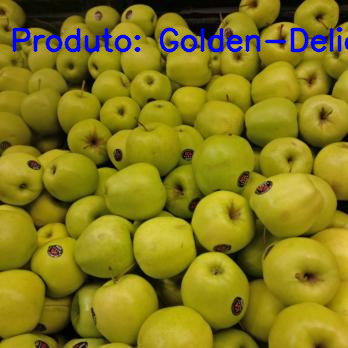

In [70]:
!pip install gTTS
import cv2
import numpy as np
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from gtts import gTTS
import IPython.display as ipd
from google.colab.patches import cv2_imshow
import os

# Carregar o modelo treinado
model = load_model('/content/classification_model.h5')

# Caminho para a imagem de teste (substitua pelo caminho da sua imagem)
caminho_imagem_teste = '/content/GroceryStoreDataset/dataset/test/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg'

# Ler a imagem de teste
image = cv2.imread(caminho_imagem_teste)

# Redimensionar a imagem para o tamanho esperado pelo modelo
image_resized = cv2.resize(image, (224, 224))

# Pré-processamento específico do InceptionV3
image_preprocessed = preprocess_input(np.expand_dims(image_resized, axis=0))

# Fazer a previsão usando o modelo treinado
predicted_label = model.predict(image_preprocessed)

# Obter o ID da classe prevista
predicted_class_id = np.argmax(predicted_label)

# Obter o nome da classe a partir do caminho da imagem
predicted_class = os.path.basename(os.path.dirname(caminho_imagem_teste))

# Exibir a imagem com a previsão
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(image, f'Produto: {predicted_class}', (10, 50), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
cv2_imshow(image)

# Gerar o arquivo de áudio com o nome do produto previsto
tts = gTTS(text=f'O produto é {predicted_class}', lang='pt')
tts.save('/content/prevision.mp3')

# Reproduzir o arquivo de áudio
ipd.Audio('/content/prevision.mp3')